# Reducers

## Experiment
The goal of the second experiment is to find the best number of composites in conjunction with the best temporal reducers that are beneficial in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Level-2A Sentinel 2 satellite imagery and indices determined by the previous experiment are used as input features.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on 1 to 12 composites in 1 step intervals with the following temporal reducers:

In [1]:
# List the available reducers (except for reducers with a NonNull variant)
from ltm.data import list_reducers

reducers = list_reducers()
reducers = [reducer
            for reducer in reducers
            if not reducer + "NonNull" in reducers]

reducers

['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinctNonNull',
 'countRuns',
 'firstNonNull',
 'kendallsCorrelation',
 'kurtosis',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

In [2]:
# List the bands determined by the previous experiment
from ltm.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance("../reports/band_importance.csv")

sentinel_bands, index_bands

Initializing Earth Engine API...


(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BCC',
  'BRBA',
  'BWDRVI',
  'GCC',
  'GVMI',
  'MCARI705',
  'MGRVI',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'NBRplus',
  'NDCI',
  'NDDI',
  'NDGI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VIBI',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'kVARI',
  'mND705',
  'mSR705'])

In [3]:
from ltm.data import sentinel_composite, split_band_name
from ltm.features import load_raster, interpolate_X, drop_nan_rows

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from itertools import product
from datetime import datetime

model = RandomForestRegressor(n_jobs=-1)
search_space = {
    "time_window": [(datetime(2017, 4, 1), datetime(2018, 4, 1))],
    "num_composites": list(range(1, 13)),
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [index_bands],
    "sentinel_bands": [sentinel_bands],
}
scoring = {
    "R2 Score": make_scorer(r2_score),
    "Mean Absolute Error": make_scorer(mean_absolute_error),
    "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False)
}
y_path = "../data/processed/y.tif"

def create_X(y_path, search_point):
    # Create X_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    X_path_to = f"../data/processed/reducer_composites/X_{reducer}_{composites}.tif"
    Path(X_path_to).parent.mkdir(parents=True, exist_ok=True)

    # Create the composite
    if not Path(X_path_to).exists():
        sentinel_composite(
            y_path_from=y_path,
            X_path_to=X_path_to,
            **search_point
        )

    # Fill missing values by linear (circular) interpolation
    X = load_raster(X_path_to)
    interpolated_X = interpolate_X(X)
    
    return interpolated_X

def callback(scores, scoring, search_point):
    print(scores)
    # Scores and Parameters of the current search point

    # Read the reducer_composites.csv
    reducer_composites = "../reports/reducer_composites.csv"
    try:
        df = pd.read_csv(reducer_composites)
    except FileNotFoundError:
        columns = ["Reducer", "Composites"] + list(scoring.keys())
        df = pd.DataFrame(columns=columns)

    # search_point["num_composite"]

    # Store the scores in the dataframe
    first_columns = [search_point["temporal_reducers"][0], search_point["num_composites"]]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring.keys()]
    df.loc[len(df)] = first_columns + last_columns

    # Save to CSV
    df.to_csv(reducer_composites, index=False)

def grid_search(model, search_space, scoring, y_path, create_X=create_X, callback=callback):
    y = load_raster(y_path)

    params = search_space.keys()
    for values in tqdm(product(*search_space.values())):
        search_point = dict(zip(params, values))
        X = create_X(y_path, search_point)
        X_no_nan, y_no_nan = drop_nan_rows(X, y)

        if len(X_no_nan) < 5:
            # TODO: synthetic cross_validate scores with NaN values
            continue
        
        scores = cross_validate(model, X_no_nan, y_no_nan, scoring=scoring, n_jobs=-1)
        callback(scores, scoring, search_point)

grid_search(model, search_space, scoring, y_path)

1it [00:05,  5.94s/it]

{'fit_time': array([0.26604629, 0.25828958, 0.2619977 , 0.26896119, 0.26592636]), 'score_time': array([0.03651643, 0.03870797, 0.03619838, 0.03708816, 0.02983642]), 'test_R2 Score': array([0.21095643, 0.28662203, 0.22466141, 0.13414086, 0.04654622]), 'test_Mean Absolute Error': array([0.36383454, 0.31701267, 0.32420119, 0.35376983, 0.38650663]), 'test_Root Mean Squared Error': array([0.41685636, 0.37684294, 0.37473716, 0.40728713, 0.44241634])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_Or_1.tif


2it [00:39, 22.16s/it]

{'fit_time': array([0.32193518, 0.31490207, 0.33668208, 0.32295513, 0.31617737]), 'score_time': array([0.05251956, 0.05199313, 0.05214834, 0.04291987, 0.04134727]), 'test_R2 Score': array([-0.0082828 , -0.01757952, -0.03529341, -0.02184662, -0.12989383]), 'test_Mean Absolute Error': array([0.44781749, 0.43151127, 0.4089728 , 0.42387388, 0.44661341]), 'test_Root Mean Squared Error': array([0.47122369, 0.45007482, 0.43302481, 0.44245582, 0.48161517])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_allNonZero_1.tif


3it [01:06, 24.42s/it]

{'fit_time': array([0.23081088, 0.23434067, 0.29257846, 0.27265525, 0.27237701]), 'score_time': array([0.0352087 , 0.03215361, 0.04683137, 0.04720926, 0.04697084]), 'test_R2 Score': array([0.20974532, 0.28698483, 0.22533513, 0.13348472, 0.04413459]), 'test_Mean Absolute Error': array([0.36405258, 0.3171394 , 0.32367692, 0.35338884, 0.38678613]), 'test_Root Mean Squared Error': array([0.41717615, 0.37674711, 0.37457431, 0.40744142, 0.44297551])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_anyNonZero_1.tif


4it [01:36, 26.46s/it]

{'fit_time': array([0.21797824, 0.2277925 , 0.24321914, 0.22274685, 0.23353767]), 'score_time': array([0.03487492, 0.03719449, 0.03537726, 0.03489041, 0.03748536]), 'test_R2 Score': array([-0.0076656 , -0.01929474, -0.03610824, -0.02239568, -0.12857567]), 'test_Mean Absolute Error': array([0.44803333, 0.43231898, 0.40928732, 0.42411495, 0.44651776]), 'test_Root Mean Squared Error': array([0.47107944, 0.45045398, 0.43319519, 0.44257468, 0.48133416])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_circularMean_1.tif


5it [02:15, 31.21s/it]

{'fit_time': array([10.0469203 , 10.2265079 ,  9.80058789, 10.19074559,  9.8443706 ]), 'score_time': array([0.1005795 , 0.03088593, 0.32923341, 0.03178477, 0.29108953]), 'test_R2 Score': array([0.59738508, 0.59734895, 0.64231351, 0.61730326, 0.52244776]), 'test_Mean Absolute Error': array([0.19558912, 0.1921419 , 0.16963314, 0.18792155, 0.22665075]), 'test_Root Mean Squared Error': array([0.29776995, 0.28311636, 0.2545261 , 0.27077243, 0.31310628])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_circularStddev_1.tif


6it [03:01, 36.07s/it]

{'fit_time': array([8.45181656, 9.93710923, 8.39735389, 8.62901664, 9.82448387]), 'score_time': array([1.24210238, 0.03125381, 1.30512905, 1.14092159, 0.04651499]), 'test_R2 Score': array([0.55132385, 0.56907866, 0.63709701, 0.62771639, 0.57130627]), 'test_Mean Absolute Error': array([0.20976   , 0.21433191, 0.16546261, 0.17794995, 0.21339899]), 'test_Root Mean Squared Error': array([0.31434201, 0.29288663, 0.25637539, 0.26706318, 0.29665721])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_circularVariance_1.tif


7it [03:38, 36.48s/it]

{'fit_time': array([9.0443325 , 9.299438  , 9.12312055, 9.78019977, 8.98154926]), 'score_time': array([0.41048694, 0.2396071 , 0.37204123, 0.03220797, 0.41865516]), 'test_R2 Score': array([0.55487407, 0.57680026, 0.64510884, 0.61767088, 0.56785156]), 'test_Mean Absolute Error': array([0.20992783, 0.21366806, 0.16422902, 0.18296384, 0.21483935]), 'test_Root Mean Squared Error': array([0.3130959 , 0.29025067, 0.25352959, 0.27064235, 0.29785014])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_count_1.tif


8it [04:09, 34.85s/it]

{'fit_time': array([0.23385143, 0.23437476, 0.22872972, 0.22331858, 0.23328567]), 'score_time': array([0.03713942, 0.03661609, 0.03519464, 0.03534627, 0.03518486]), 'test_R2 Score': array([0.2261904 , 0.32714258, 0.28794659, 0.13619629, 0.07066923]), 'test_Mean Absolute Error': array([0.35543477, 0.30441258, 0.31006787, 0.34670694, 0.37476511]), 'test_Root Mean Squared Error': array([0.41281265, 0.36598397, 0.35911814, 0.40680342, 0.43678378])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_countDistinctNonNull_1.tif


9it [04:44, 34.61s/it]

{'fit_time': array([0.33397889, 0.34128237, 0.34026957, 0.33778143, 0.3289907 ]), 'score_time': array([0.03440166, 0.03392339, 0.04405618, 0.03392339, 0.03354859]), 'test_R2 Score': array([ 0.19924611,  0.23338779,  0.21566767, -0.03143898,  0.07800344]), 'test_Mean Absolute Error': array([0.34350476, 0.30045342, 0.30217121, 0.36215355, 0.37378588]), 'test_Root Mean Squared Error': array([0.41993828, 0.39065052, 0.37690432, 0.4445277 , 0.43505683])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_countRuns_1.tif


10it [05:15, 33.75s/it]

{'fit_time': array([0.28952217, 0.27978802, 0.28536749, 0.30842948, 0.31236172]), 'score_time': array([0.041224  , 0.04972696, 0.04015326, 0.03300691, 0.03765893]), 'test_R2 Score': array([0.22741122, 0.24266311, 0.18737343, 0.05462409, 0.1043632 ]), 'test_Mean Absolute Error': array([0.34416041, 0.30379604, 0.31934339, 0.35345988, 0.3738961 ]), 'test_Root Mean Squared Error': array([0.41248688, 0.38828007, 0.38364237, 0.42557815, 0.42879263])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_firstNonNull_1.tif


11it [05:59, 36.78s/it]

{'fit_time': array([8.25214005, 8.08617258, 8.30165529, 8.00068521, 8.39879584]), 'score_time': array([0.03645921, 0.19931984, 0.03164172, 0.27728081, 0.03300428]), 'test_R2 Score': array([0.54453565, 0.60045404, 0.62735554, 0.60933005, 0.44047161]), 'test_Mean Absolute Error': array([0.19904871, 0.18128246, 0.17058069, 0.18546645, 0.25088239]), 'test_Root Mean Squared Error': array([0.31671099, 0.2820226 , 0.25979357, 0.27357856, 0.33891626])}
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/reducer_composites/X_kendallsCorrelation_1.tif


11it [06:33, 35.81s/it]


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

In [ ]:
a= [1]
b = [2, 3]
c = [4, 5, 6, 7, 8]

d = [a, b, c]

list(product(*d))

[(1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 2, 8),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (1, 3, 8)]

In [ ]:
# Optional: Interpolate missing values in X, save it as a new raster and visualize it
from ltm.data import show_timeseries
from ltm.features import load_raster, interpolate_X, save_raster

# Define paths and parameters
X_path = "tmp.tif"
interpolated_X_path = "interpolated.tif"
visualized_reducer = "min"
rgb_bands = ["B4", "B3", "B2"]

# Load, interpolate and save new X
X = load_raster(X_path)
interpolated_X = interpolate_X(X)
save_raster(interpolated_X, X_path, interpolated_X_path)

# Visualize
show_timeseries(interpolated_X_path, visualized_reducer, rgb_bands=rgb_bands)

Notice that we removed any reducer that has a "NonNull" variant. This is because we do not want NaN values in the dataset for this paper.

Now we can conduct the experiment. The following cell creates one raster per temporal reducer using the GEE API and stores it with the naming scheme "data/processed/X_{temporal_reducer}.tif". Each raster is then used to evaluate a random forest model using 5-fold cross validation. The results are saved to "reports/reducers.csv".

In [ ]:
# Evaluate a model for each reducer
from ltm.data import list_bands, sentinel_composite
from ltm.features import load_raster, drop_nan_rows
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from pathlib import Path
import pandas as pd

reducers_path = "../reports/reducers.csv"
if not Path(reducers_path).exists():
    # Define the label path and the bands to use
    y_path = "../data/processed/y.tif"
    sentinel_bands = [band for band in list_bands() if band.startswith("B")]

    # Define the scoring metrics
    scoring = {
        "R2 Score": make_scorer(r2_score),
        "Mean Absolute Error": make_scorer(mean_absolute_error),
        "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False)
    }

    score_df = pd.DataFrame(columns=scoring.keys())
    for reducer in reducers:
        # Create the composite for current reducer
        X_path = f"../data/processed/reducers/X_{reducer}.tif"
        if not Path(X_path).exists():
            Path(X_path).parent.mkdir(parents=True, exist_ok=True)
            sentinel_composite(
                y_path_from=y_path,
                X_path_to=X_path,
                time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
                temporal_reducers=[reducer],
                sentinel_bands=sentinel_bands,
            )

        # Load the data and drop rows containing NaNs
        X = load_raster(X_path)
        y = load_raster(y_path)
        X, y = drop_nan_rows(X, y)

        # Handle case where less than 5 samples are left (due to 5-fold cross-validation)
        if X.shape[0] < 5:
            score_df.loc[reducer] = [np.nan] * len(scoring)
            continue

        # Evaluate the model
        random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
        scores = cross_validate(random_forest, X, y, scoring=scoring, n_jobs=-1)
        score_df.loc[reducer] = [scores[f"test_{key}"].mean() for key in scoring.keys()]

    # Save the scores
    score_df.to_csv(reducers_path, index_label="Reducer")
else:
    score_df = pd.read_csv(reducers_path, index_col=0)

score_df

,R2 Score,Mean Absolute Error,Root Mean Squared Error
Reducer,,,
And,-0.042684,0.431939,0.455699
Or,-0.042684,0.431939,0.455699
allNonZero,-0.042684,0.431939,0.455699
anyNonZero,-0.042684,0.431939,0.455699
circularMean,0.538389,0.211784,0.303150
circularStddev,0.560304,0.205168,0.295925
circularVariance,0.559884,0.205360,0.296071
count,-0.042684,0.431939,0.455699
countDistinctNonNull,0.277344,0.295775,0.379318


To decide which temporal reducers are suitable for the task, we (arbitrarily) choose the following criteria:
- The $R^2$ score must be positive.

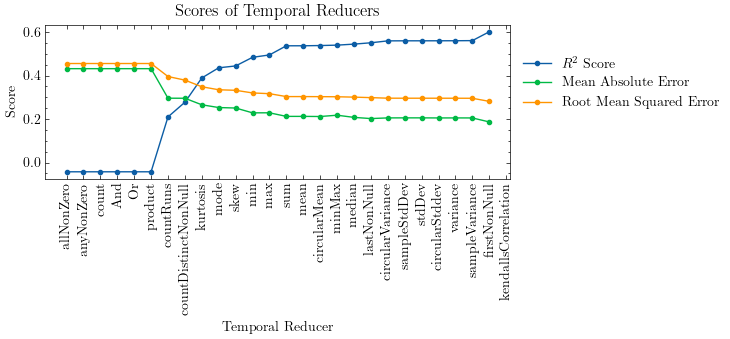

In [ ]:
from ltm.models import plot_report
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = plot_report(
    score_df.sort_values("R2 Score"),
    "Scores of Temporal Reducers",
    "Temporal Reducer",
    "Score",
    label_rotation=90,
    replace_labels={"R2 Score": "$R^2$ Score"},
    figsize=(6, 2),
    marker="."
)

plt.show()

# Result

The following temporal reducers are considered suitable for the task and are used for the next experiment:

In [ ]:
for reducer in sorted(score_df[score_df["R2 Score"] > 0].index):
    print(reducer)

circularMean
circularStddev
circularVariance
countDistinctNonNull
countRuns
firstNonNull
kurtosis
lastNonNull
max
mean
median
min
minMax
mode
sampleStdDev
sampleVariance
skew
stdDev
sum
variance


# Compositing

Composite length ranging from 1 to 12 months. NaN values are interpolated linearly.

In [ ]:
# Optional: Interpolate missing values in X, save it as a new raster and visualize it
from ltm.data import show_timeseries
from ltm.features import load_raster, interpolate_X, save_raster

# Define paths and parameters
X_path = "tmp.tif"
interpolated_X_path = "interpolated.tif"
visualized_reducer = "min"
rgb_bands = ["B4", "B3", "B2"]

# Load, interpolate and save new X
X = load_raster(X_path)
interpolated_X = interpolate_X(X)
save_raster(interpolated_X, X_path, interpolated_X_path)

# Visualize
show_timeseries(interpolated_X_path, visualized_reducer, rgb_bands=rgb_bands)